This notebook aims to create a template of model development, and use XGBoost as an example. For the other models, the idea is similar with minor changes in specific scripts.

# Import Libraries

In [1]:
# Basic 
import pandas as pd
import numpy as np
import pickle
import yaml
from itertools import product

# Model development
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from hyperopt import STATUS_OK, hp, tpe, Trials, fmin
from random import sample
import xgboost as xgb
from xgboost import plot_importance

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Other
import warnings
warnings.filterwarnings('ignore')

# Custom
from utils import *

# User-Defined Parameters

Section to collect all parameters and hyperparameters that impact model development in order to avoid manually modifying in the sections below

In [2]:
with open('config.yml') as file:
    config = yaml.safe_load(file)

In [3]:
TARGET_VAR = config['model_develop']['features']['target_var']
FEATURE_VARS = config['model_develop']['features']['feature_vars']

SEP_VAR = config['model_develop']['sampling']['sep_var']
SAMPLE_RATIO = config['model_develop']['sampling']['sample_ratio']

MODEL_OTHERS = config['model_develop']['others']

MODELFILE = config['filepaths']['output']['modelfile']

In [4]:
SPACE = {
    'colsample_bytree': hp.uniform('colsample_bytree', 0, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'n_estimators': hp.choice('n_estimators', np.arange(200, 1000, dtype=int)),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.3, 1),
    'max_depth': hp.choice('max_depth', np.arange(3, 5, dtype=int)),
    'subsample': hp.uniform('subsample', 0.5, 1), 
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Load and Process Data

In [5]:
boston = datasets.load_boston()
data = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
data['target'] = boston['target']

# print(boston['DESCR'])
print(data.shape)
data.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# Sample Strategy

In [6]:
X_train, y_train, X_dev, y_dev, X_test, y_test = split_data(
    data, TARGET_VAR, SEP_VAR, MODEL_OTHERS['random_state'], SAMPLE_RATIO)
print(X_train.shape, X_dev.shape, X_test.shape)

(324, 13) (81, 13) (101, 13)


# Model Development

In [7]:
model = fit_model(X_train, y_train, X_dev, y_dev, {}, MODEL_OTHERS)

[18:23:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "objectives" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [8]:
eval_model(model, X_test, y_test, _print=True)

MAE: 2.822, RMSE: 4.431, R2: 0.774


{'mae': 2.822, 'rmse': 4.431, 'r2': 0.774}

# Hyperparameters Finetune

## First: Find Optimal Values

In [9]:
def bayes_fn(params):
    """Function used to find the optimal hyperparameters for model
    Input
    params: a dictionary which is the space composed of choices for different hyperparameters
    """
    
    estimator = xgb.XGBRegressor(**params, random_state=MODEL_OTHERS['random_state'],
                                 objectives='reg:squarederror')
    estimator.fit(X_train,
                y_train,
                eval_set=[(X_dev, y_dev)],
                eval_metric=MODEL_OTHERS['eval_metric'],
                early_stopping_rounds=MODEL_OTHERS['earlystop'],
                verbose=False)
    
    score = np.sqrt(metrics.mean_absolute_error(y_dev, estimator.predict(X_dev)))
    
    return {'loss': score, 'params': params, 'status': STATUS_OK}

In [10]:
%%time
bayes_trials1 = Trials()
best_params = fmin(fn=bayes_fn, space=SPACE, algo=tpe.suggest, max_evals=10, trials=bayes_trials1)

[18:23:48] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "objectives" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:23:50] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parameters: { "objectives" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:23:51] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627:                   
Parame

In [11]:
best_params

{'colsample_bylevel': 0.9120694547004911,
 'colsample_bytree': 0.646319791613206,
 'learning_rate': 0.0912791042486038,
 'max_depth': 1,
 'n_estimators': 427,
 'reg_alpha': 0.7233946524966508,
 'reg_lambda': 0.3589550930855274,
 'subsample': 0.6714714658459169}

In [12]:
model = fit_model(X_train, y_train, X_dev, y_dev, best_params, MODEL_OTHERS)
eval_model(model, X_dev, y_dev, _print=True)

[18:24:01] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "objectives" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


MAE: 2.387, RMSE: 3.279, R2: 0.868


{'mae': 2.387, 'rmse': 3.279, 'r2': 0.868}

## Second: Grid Search

Grid search in the neighbour around best parameters

In [13]:
grid_params = {
    'colsample_bylevel': [0.4, 0.5],
    'colsample_bytree': [0.7, 0.8],
    'learning_rate': [0.02, 0.04],
    'max_depth': [1, 2],
    'n_estimators': [200],
    'reg_alpha': [0.2],
    'reg_lambda': [0.8],
    'subsample': [0.9]
}

In [14]:
%%time
result = grid_search_result(grid_params, X_train, y_train, X_dev, y_dev, MODEL_OTHERS)

[18:24:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "objectives" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:24:02] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "objectives" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[18:24:03] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "objectives" } might not be used.

  This coul

In [15]:
result.head()

,colsample_bylevel,colsample_bytree,learning_rate,max_depth,n_estimators,reg_alpha,reg_lambda,subsample,train_mae,train_rmse,train_r2,val_mae,val_rmse,val_r2
0,0.4,0.7,0.02,1.0,200.0,0.2,0.8,0.9,2.854,3.975,0.813,3.225,4.826,0.715
1,0.4,0.7,0.02,2.0,200.0,0.2,0.8,0.9,2.143,2.943,0.897,2.665,3.808,0.822
2,0.4,0.7,0.04,1.0,200.0,0.2,0.8,0.9,2.299,3.159,0.882,2.884,4.097,0.794
3,0.4,0.7,0.04,2.0,200.0,0.2,0.8,0.9,1.699,2.275,0.939,2.552,3.352,0.862
4,0.4,0.8,0.02,1.0,200.0,0.2,0.8,0.9,2.796,3.889,0.821,3.181,4.709,0.728


val data: min_mae = 2.358, min_rmse = 3.133, max_r2 = 0.88


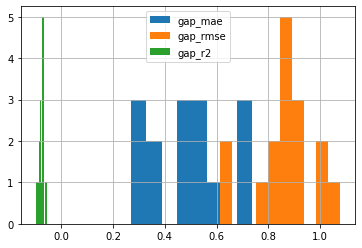

In [16]:
for i in ['mae', 'rmse', 'r2']:
    result['gap_' + i] = result['val_'+i] - result['train_'+i]
    result['gap_' + i].hist(legend=True)
    
print(f'val data: min_mae = {result["val_mae"].min()}, min_rmse = {result["val_rmse"].min()}, max_r2 = {result["val_r2"].max()}')

In [17]:
result.loc[(result['gap_mae']<0.4)].sort_values(by='val_mae', ascending=True)

,colsample_bylevel,colsample_bytree,learning_rate,max_depth,n_estimators,reg_alpha,reg_lambda,subsample,train_mae,train_rmse,train_r2,val_mae,val_rmse,val_r2,gap_mae,gap_rmse,gap_r2
14,0.5,0.8,0.04,1.0,200.0,0.2,0.8,0.9,2.236,3.11,0.885,2.563,3.724,0.83,0.327,0.614,-0.055
12,0.5,0.8,0.02,1.0,200.0,0.2,0.8,0.9,2.678,3.723,0.836,2.949,4.373,0.766,0.271,0.65,-0.07
8,0.5,0.7,0.02,1.0,200.0,0.2,0.8,0.9,2.743,3.797,0.829,3.056,4.554,0.746,0.313,0.757,-0.083
4,0.4,0.8,0.02,1.0,200.0,0.2,0.8,0.9,2.796,3.889,0.821,3.181,4.709,0.728,0.385,0.82,-0.093
0,0.4,0.7,0.02,1.0,200.0,0.2,0.8,0.9,2.854,3.975,0.813,3.225,4.826,0.715,0.371,0.851,-0.098


In [18]:
result.loc[(result['gap_mae']<0.4)].sort_values(by='val_rmse', ascending=True)

,colsample_bylevel,colsample_bytree,learning_rate,max_depth,n_estimators,reg_alpha,reg_lambda,subsample,train_mae,train_rmse,train_r2,val_mae,val_rmse,val_r2,gap_mae,gap_rmse,gap_r2
14,0.5,0.8,0.04,1.0,200.0,0.2,0.8,0.9,2.236,3.11,0.885,2.563,3.724,0.83,0.327,0.614,-0.055
12,0.5,0.8,0.02,1.0,200.0,0.2,0.8,0.9,2.678,3.723,0.836,2.949,4.373,0.766,0.271,0.65,-0.07
8,0.5,0.7,0.02,1.0,200.0,0.2,0.8,0.9,2.743,3.797,0.829,3.056,4.554,0.746,0.313,0.757,-0.083
4,0.4,0.8,0.02,1.0,200.0,0.2,0.8,0.9,2.796,3.889,0.821,3.181,4.709,0.728,0.385,0.82,-0.093
0,0.4,0.7,0.02,1.0,200.0,0.2,0.8,0.9,2.854,3.975,0.813,3.225,4.826,0.715,0.371,0.851,-0.098


## Finalize

In [19]:
final_params = {'colsample_bylevel': 0.6,
 'colsample_bytree': 0.7,
 'learning_rate': 0.04,
 'max_depth': 2,
 'n_estimators': 400,
 'reg_alpha': 0.2,
 'reg_lambda': 0.5,
 'subsample': 0.9}

model = fit_model(X_train, y_train, X_dev, y_dev, best_params, MODEL_OTHERS)
perf_test = eval_model(model, X_test, y_test, _print=True)

[18:24:08] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "objectives" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


MAE: 3.05, RMSE: 5.395, R2: 0.665


### Model Performance

In [20]:
def plot_model(model, X_test, y_test):
    pred = pd.DataFrame({'y': y_test, 'pred_y': model.predict(X_test)})
    plt.scatter(pred['y'], pred['pred_y'])
    plt.xlim(min(pred.min()), max(pred.max()))
    plt.ylim(min(pred.min()), max(pred.max()))

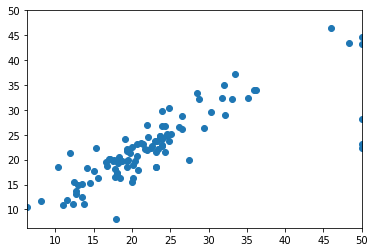

In [21]:
plot_model(model, X_test, y_test)

### Feature Importance

In [22]:
def plot_feature_imp(model, max_num_features=10):
    booster = model.get_booster()

    # Get the importance dictionary (by gain) from the booster
    importance = booster.get_score(importance_type="gain")

    # make your changes
    for key in importance.keys():
        importance[key] = round(importance[key],2)

    # provide the importance dictionary to the plotting function
    ax = plot_importance(importance, max_num_features=max_num_features, importance_type='gain', show_values=True)

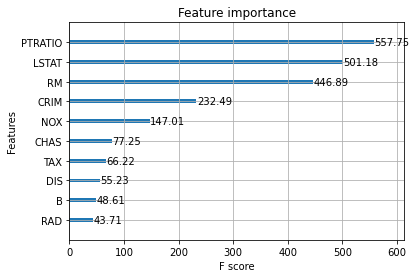

In [23]:
plot_feature_imp(model)